# Anlysis for the particle on a ring simulations

In [271]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as patche
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from numba.experimental import jitclass
from scipy.optimize import curve_fit
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.3*fig[1],
         'axes.labelsize': 2.3*fig[1],
         'axes.titlesize': 2.6*fig[1],
         'xtick.labelsize': 2*fig[1],
         'ytick.labelsize': 2*fig[1],
         'font.family' : 
          'serif'
          }
pylab.rcParams.update(params)

In [272]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [273]:
@njit(parallel=True)
def correlation(data, stop):
#compute the auto-correlation time of an observable for a given simulation 
    # corr = np.array(
    #     [(data**2).mean() - (data.mean())**2] + [(data[:-k] * data[k:]).mean() - (data.mean())**2 for k in range(1,stop)]
    # )
    # if corr[0]!=0: corr_norm = corr/corr[0]
    # corr = np.zeros(stop)
    # for k in prange(stop):
    #     for i in range(1,len(data) - k):
    #         corr[k] += (1/(len(data)-k)) * (data[i]*data[k+i])
    #     corr[k] = corr[k] - (data.mean())**2
    
    corr = np.zeros(stop)
    d_mean = data.mean()
    for k in prange(stop):
        for i in range(1,len(data) - k):
            corr[k] += (1/(len(data)-k)) * (data[i] - d_mean) * (data[i+k] - d_mean)    
    return corr
    

In [274]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [275]:
def f_corr(x, a, tau):
    return a * np.exp(-x/tau)    

In [276]:
#directories for accessing the simulation for the different algorithms used
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [277]:
#key to access all the data 
a=np.geomspace(0.001,1,200)
b=np.geomspace(0.001,0.00103,30)
N = np.unique((10/a).astype(int))
N1 = np.unique((10/b).astype(int))
N2 = np.concatenate((N,N1))
N = N2[:-1]

### Autocorrelation time for Metro + Tailor 

In [324]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
etas = []
tau_s = []
ene_s = []
de = []
dt = []
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[30000:]/4))
    corr = correlation(charges[30000:], stop)
    corr_e = correlation(enes[30000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    d_ene = np.full(len(corr_e),blocking(enes, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas.append(10/ns)
    tau_s.append(opt[1])
    dt.append(cov[1,1]**(1/2))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_ene, p0=(1, 1))
    ene_s.append(opt[1])
    de.append(cov[1,1]**(1/2))

  0%|          | 0/217 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)


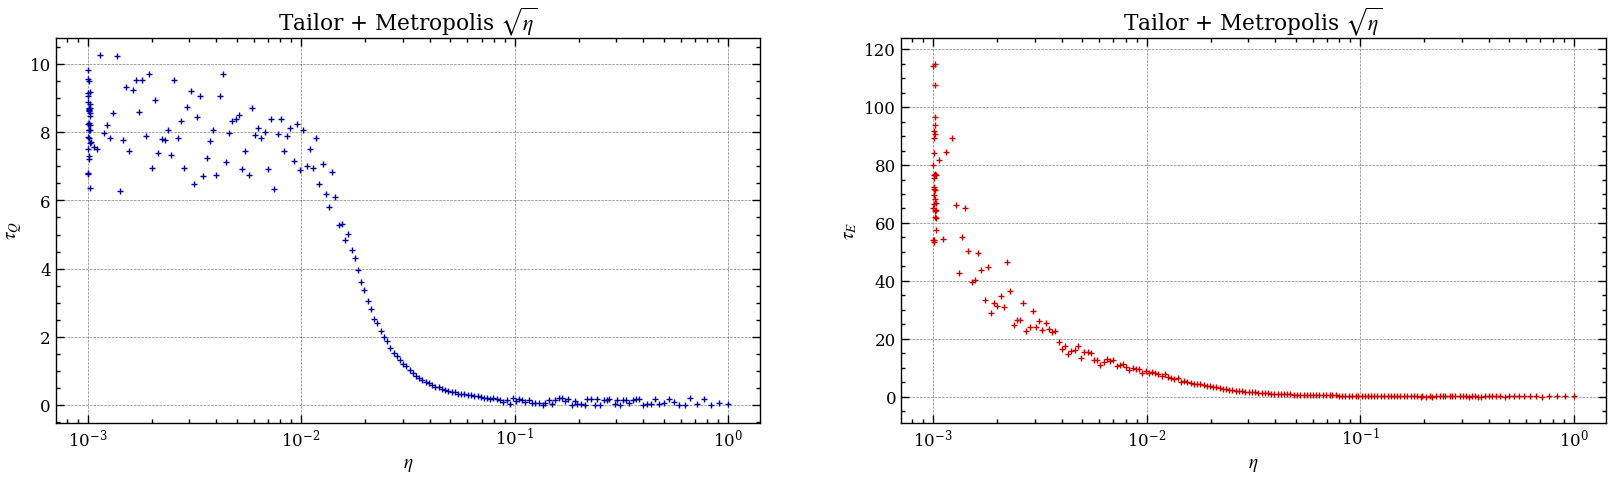

In [326]:
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Tailor + Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(tau_s),'+',markersize='5', linewidth='.4',color=getColor('jet', 30,1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')


plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Tailor + Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(ene_s),'+',markersize='5', linewidth='.4',color=getColor('jet', 30,27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')
plt.ylim(None, 124)
#plt.xlim(0.001,0.01)

plt.savefig('corr_tailor', dpi=500)

### Autocorrelation time for Metropolis 

In [327]:
etas_m = []
taus_m = []
enes_m = []
de_m = []
dt_m = []
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[1000:]/4))
    corr = correlation(charges[1000:], stop)
    corr_e = correlation(enes[1000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas_m.append(10/ns)
    taus_m.append(opt[1])
    dt_m.append(np.sqrt(cov[1,1]))
    d_enes =np.full(len(corr_e),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_enes, p0=(1, 1))
    enes_m.append(opt[1])
    de_m.append(np.sqrt(cov[1,1]))

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/2412429490.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


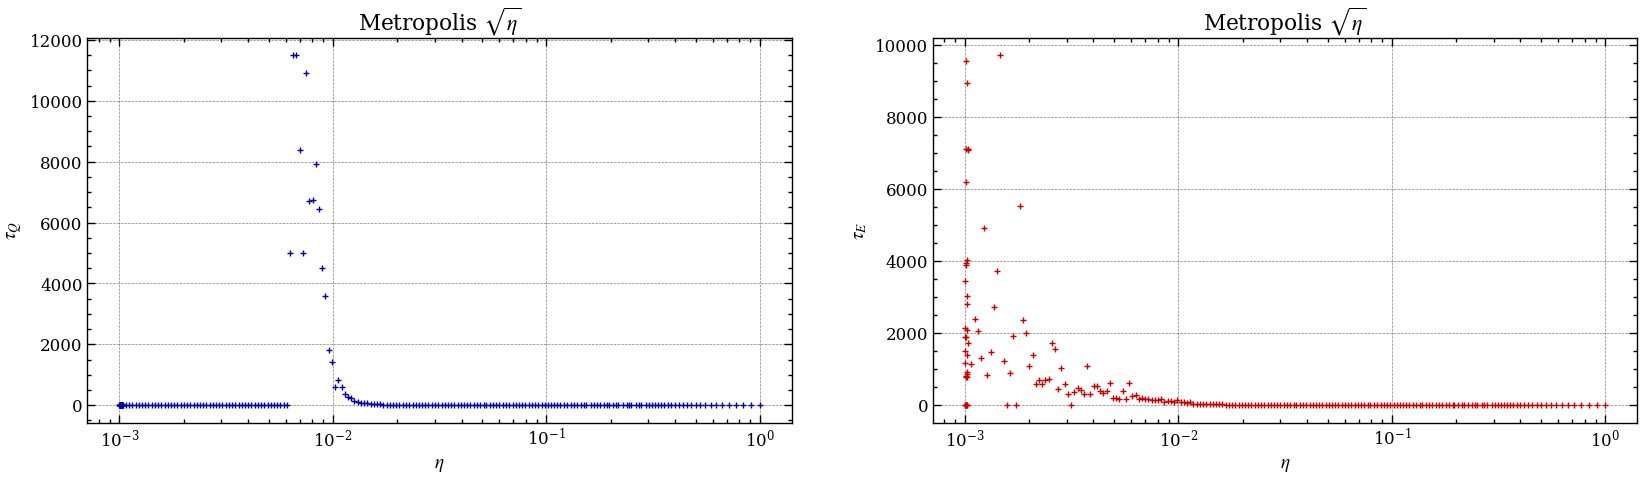

In [328]:
plt.figure(figsize=(20,5))
plt.title('') 

plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(taus_m),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')

plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(enes_m),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')
#plt.ylim(None,1000)
#plt.xlim(0.001,0.01)
plt.savefig('corr_metro', dpi=500)

### autocorrelation time for Metro $\eta=1/2$ 

In [329]:
etas_m05 = []
taus_m05 = []
enes_m05 = []
dt_m05 = []
de_m05 = []
names = os.getcwd() + '/' + dir3 + '/' + 'simulation'
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[1000:]/4))
    corr = correlation(charges[1000:], stop)
    corr_e = correlation(enes[1000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas_m05.append(10/ns)
    taus_m05.append(opt[1])
    dt_m05.append(np.sqrt(cov[1,1]))
    d_enes =np.full(len(corr_e),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_enes, p0=(1, 1))
    enes_m05.append(opt[1])
    de_m05.append(np.sqrt(cov[1,1]))

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)


/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/2193896410.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


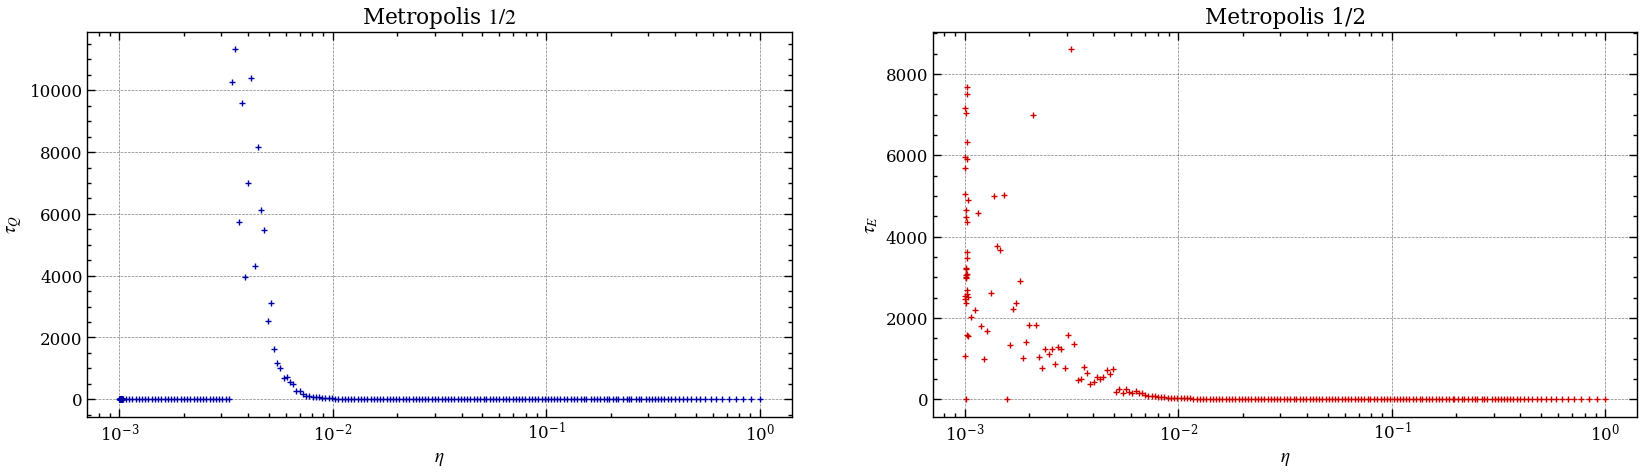

In [330]:
plt.figure(figsize=(20, 5))
plt.title('') 

plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $1/2$')
plt.plot(np.array(etas) , np.array(taus_m05),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')


plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Metropolis 1/2')
plt.plot(np.array(etas) , np.array(enes_m05),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')

#plt.ylim(None,1000)
#plt.xlim(0.001,0.01)
plt.savefig('corr_metro05', dpi=500)

## Some Mc stories for the diff algorithms

In [504]:
10/8703

0.001149029070435482

Text(0.5, 0, 'MC time')

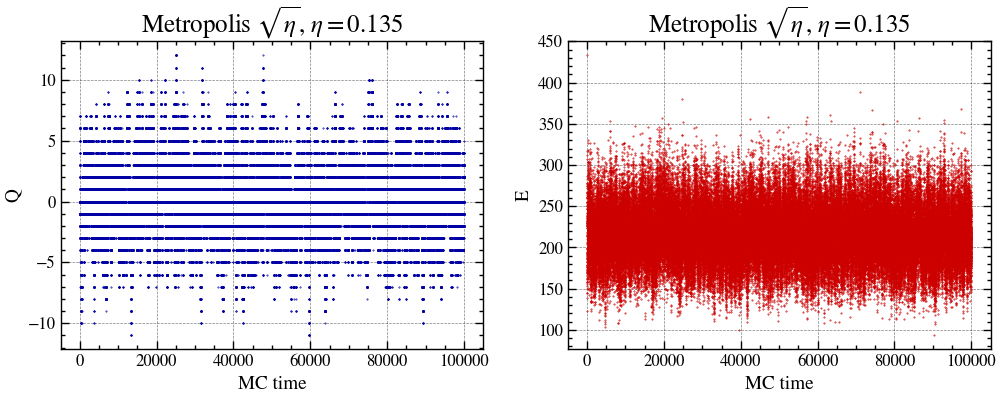

In [512]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(18,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.135$")
charges, enes = np.loadtxt(f'{names}_740.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.135$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')

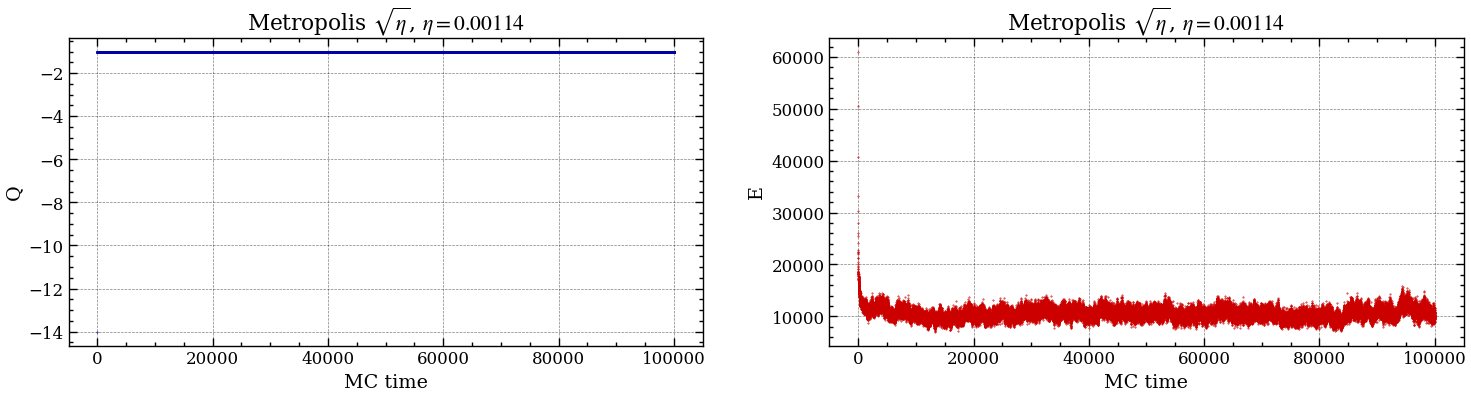

In [299]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(18,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.00114$")
charges, enes = np.loadtxt(f'{names}_8703.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.00114$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')
plt.savefig('mcstorymetro_cont', dpi=500)

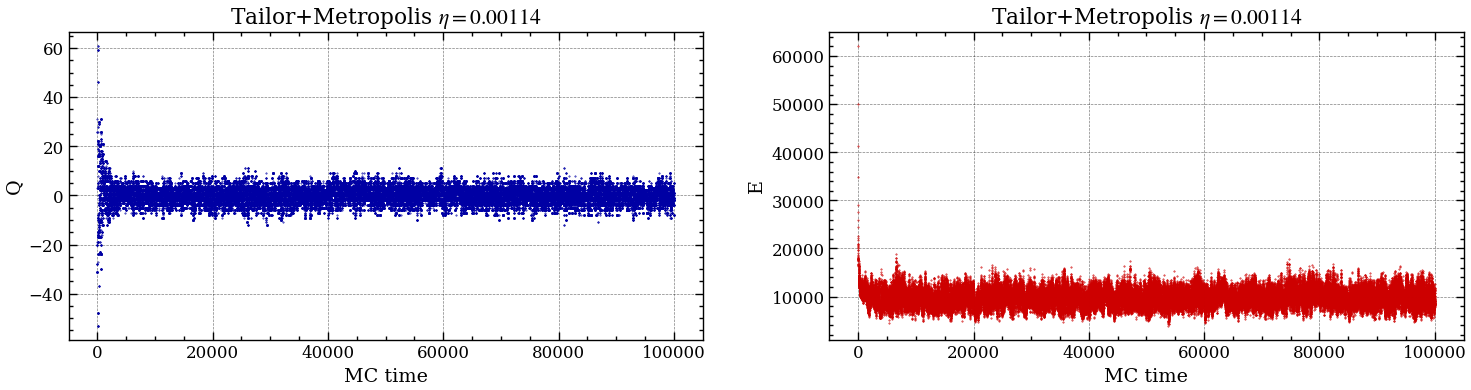

In [298]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(18,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(rf"Tailor+Metropolis $\eta=0.00114$")
charges, enes = np.loadtxt(f'{names}_8703.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(rf"Tailor+Metropolis $\eta=0.00114$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')
plt.savefig('mcstorytailor_cont', dpi=500)

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/3656140164.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


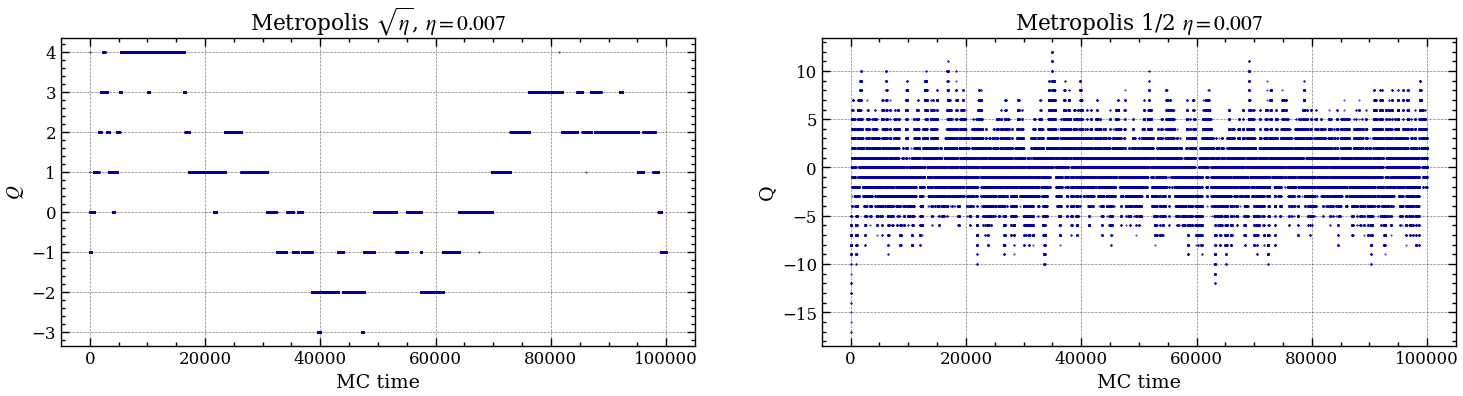

In [323]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(18,4)) #b10
plt.title('') 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.007$")
charges, enes = np.loadtxt(f'{names}_1289.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'$Q$')
plt.xlabel('MC time')
#plt.xlim(0, 90000)
#turbojetplt.ylim(-10, 10)
plt.subplot(1, 2, 2)
names = os.getcwd() + '/' + dir3+ '/' + 'simulation'
plt.title(rf"Metropolis 1/2 $\eta=0.007$")
charges, enes = np.loadtxt(f'{names}_1289.txt', unpack=True)    
plt.plot(charges,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.savefig('mcstory05_diff', dpi=500)

# Istogrammi 

In [331]:
eta_hist=np.array([1.0, 0.125, 0.0625, 0.001008267795926598])

In [20]:
np.sort(N)[etas == eta_hist[0]][0]

10

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_96768/2812255232.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,4,i+1)


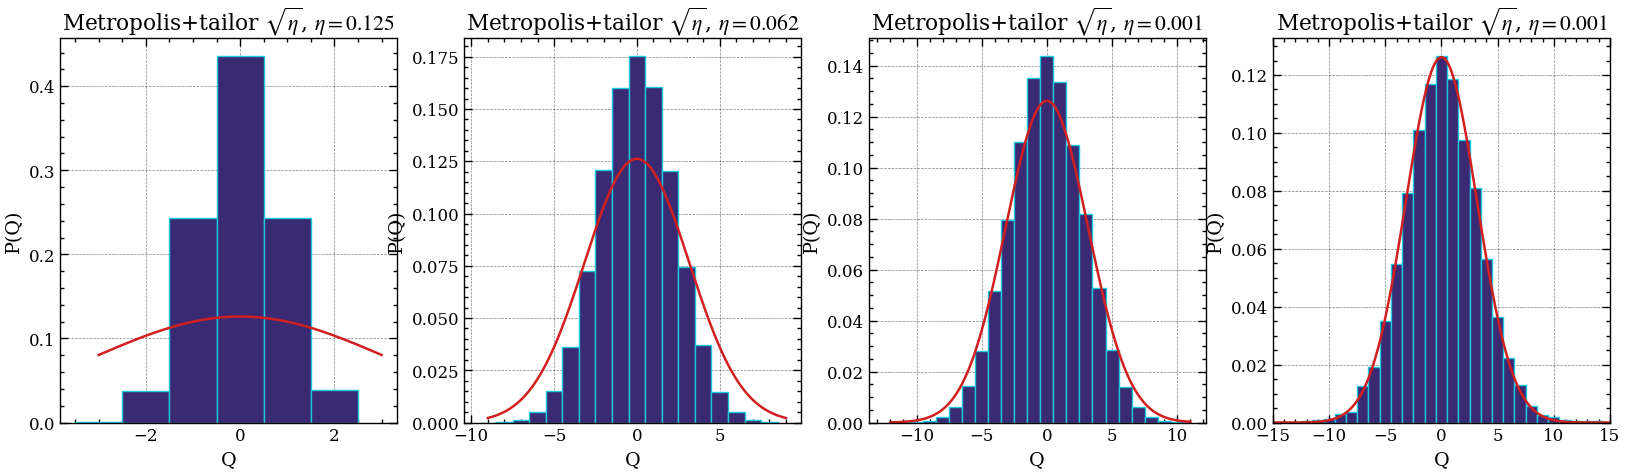

In [332]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(20,5))
plt.title('ciao')

for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)

    b=int(charges.max()-charges.min())
    plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    
    plt.subplot(1,4,i+1)
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21),label= 'label')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
    

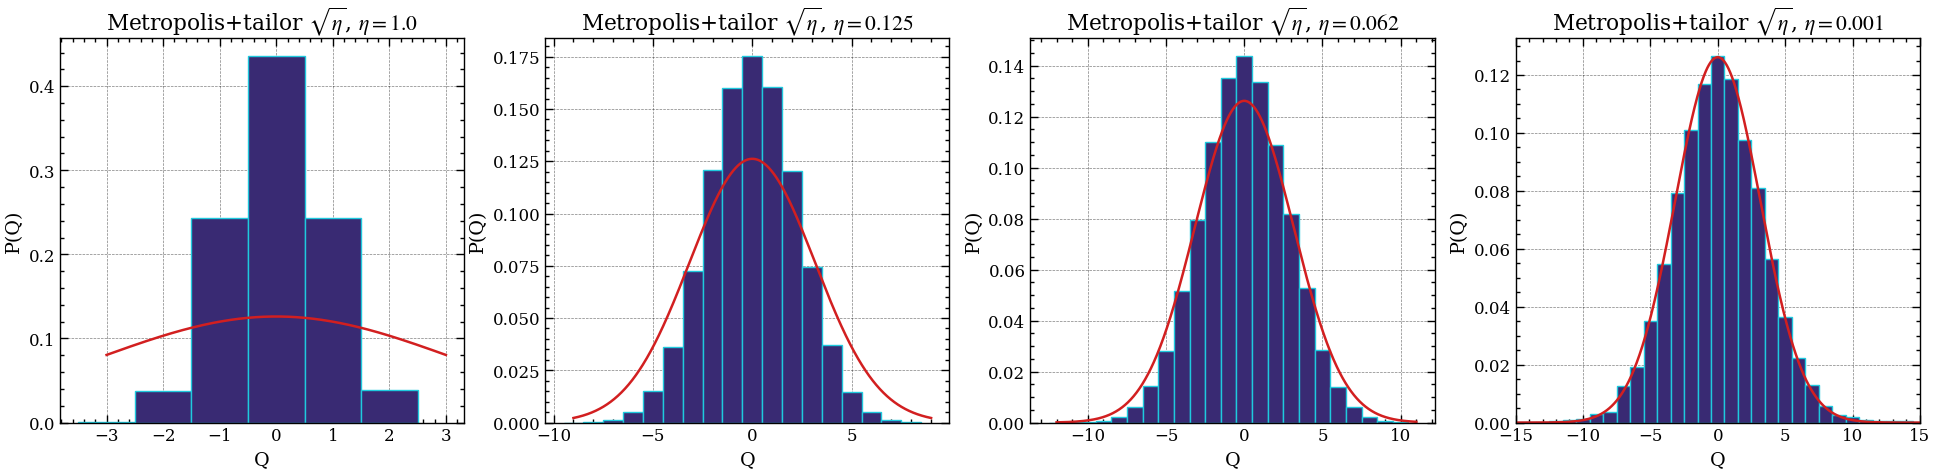

In [336]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(24,5))
for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)
    if i == 3: x = np.linspace(-15,15,1000)   #obbrobrio 
    b=int(charges.max()-charges.min()) 
    plt.subplot(1,4,i+1)
    plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21),label= 'label')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
    
plt.savefig('isto_tailor', dpi=500)

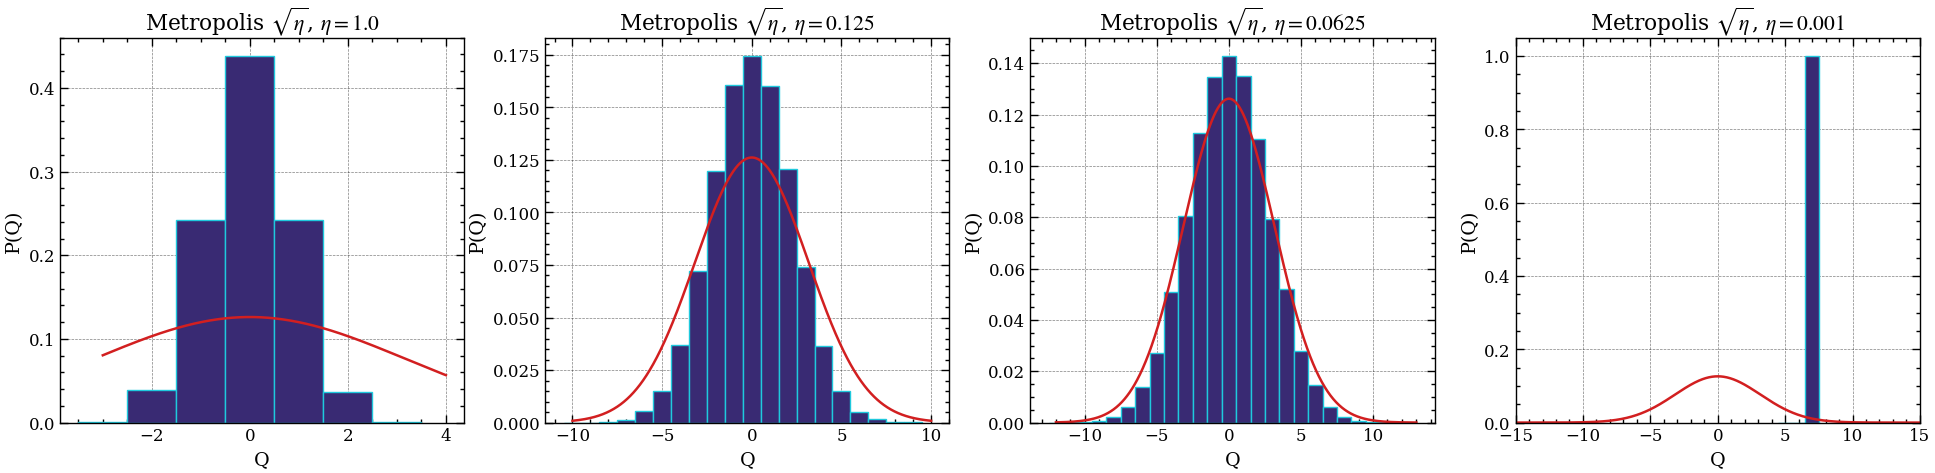

In [337]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(24,5))
for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)
    if i == 3: x = np.linspace(-15,15,1000)   #obbrobrio 
    b=int(charges.max()-charges.min()) 
    plt.subplot(1,4,i+1)
    plt.title(r'Metropolis $\sqrt{\eta}$,' f' $\eta = {e}$')
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21),label= 'label')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(r'Metropolis $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
    
plt.savefig('isto_metro', dpi=500)

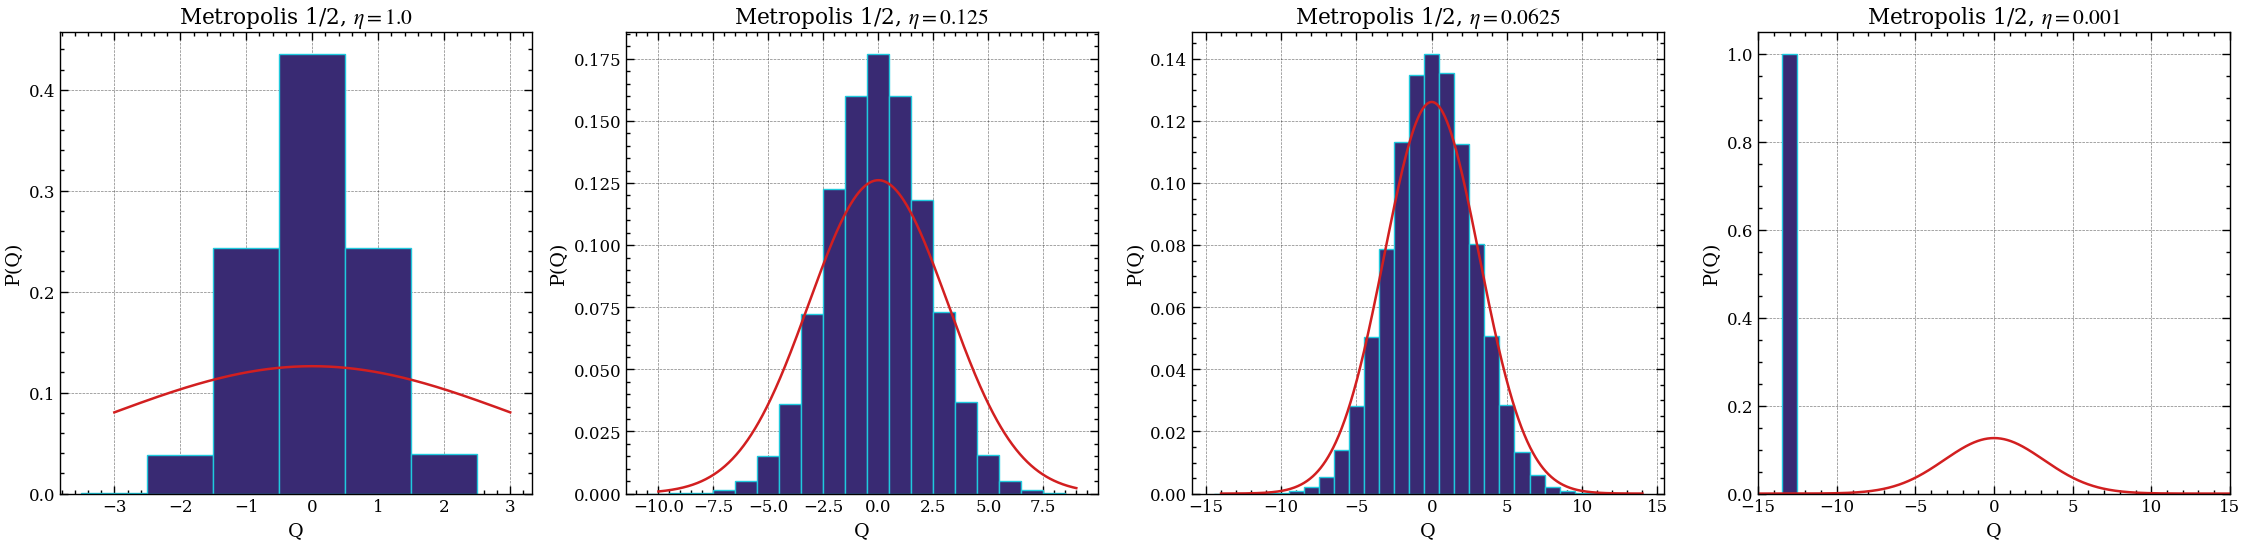

In [342]:
names = os.getcwd() + '/' + dir3 + '/' + 'simulation'
plt.figure(figsize=(28,6))
for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)
    if i == 3: x = np.linspace(-15,15,1000)   #obbrobrio 
    b=int(charges.max()-charges.min())
    plt.subplot(1,4,i+1)
    plt.title(fr'Metropolis 1/2, $\eta = {e}$') 
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21), label='theoretical')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(fr'Metropolis 1/2, $\eta = {round(eta_hist[3],3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
plt.savefig('isto_05', dpi=500)

In [412]:
for i,e in enumerate(eta_hist):
    print(e)

1.0
0.125
0.0625
0.001008267795926598


# Varianza (estrapolazione al continuo) 

In [344]:
   #put in input the std(|q|) for each eta and it gives you the correct estimate of the error
def bootstrap_binned(data, bin_size, f, R):
    nb = int(len(data)/bin_size) #num of blocks
    re_samples = np.full(R,0.) #each row will contain the fake resampling std
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    #let's pick randomly the block until all the sample is full
    tmp = np.full((nb,bin_size), 0.)
    for j in range(R):
        for k, b in enumerate(np.random.randint(0, nb, size=nb)):
            tmp[k] = blocks[b]
        re_samples[j] = f(tmp.flatten())
    return re_samples

In [345]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [346]:
def var_abs(data):
    return abs(data).std(ddof=1)**2

In [347]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [348]:
eta_hist=np.array([0.007757951900698216, 0.005479452054794521, 0.001008267795926598, 0.11235955056179775, 0.045662100456621])

In [353]:
titles=['Tailor + Metropolis',r'Metropolis $\sqrt{\eta}$',r'Metropolis 1/2']

'Metropolis 1/2'

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

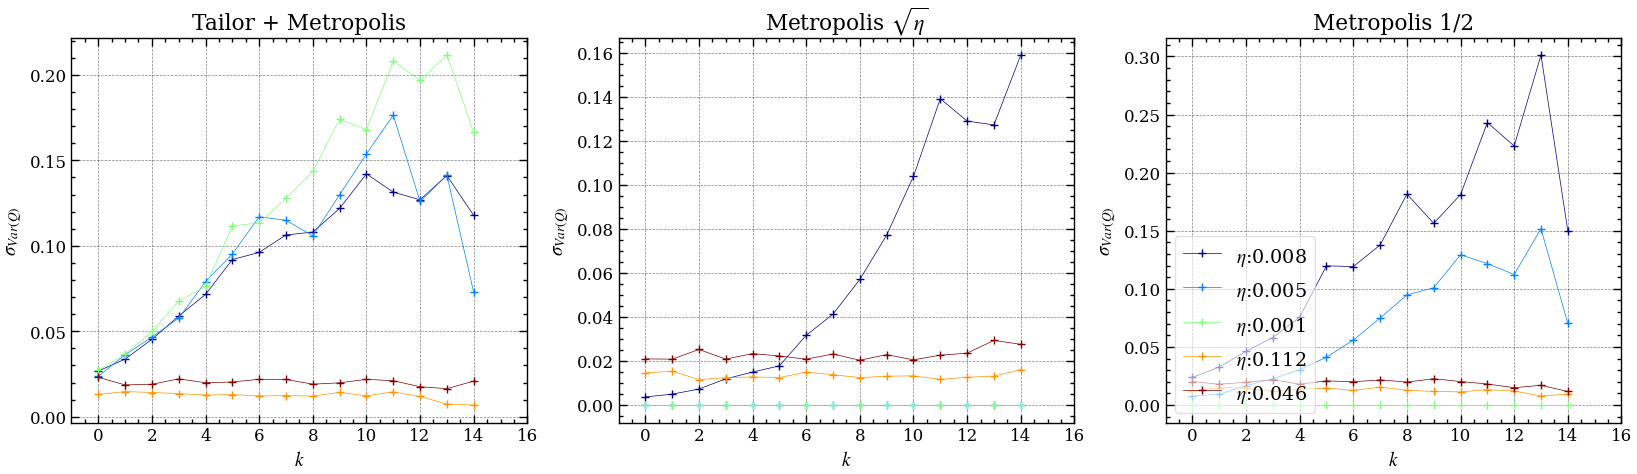

In [359]:
#best block/number of resamples
dirs = [dir1, dir2, dir3]
N_start=34464
plt.figure(figsize=(20,5))
for idx, d in enumerate(dirs):
    names = os.getcwd() + '/' + d + '/' + 'simulation'
    for i,file in enumerate(tqdm(eta_hist)):
        key = np.sort(N)[etas == eta_hist[i]][0]
        sigma_q_try =[]
        charges, ene = np.loadtxt(f'{names}_{key}.txt', unpack=True)
        for k in range(0,15):
            dq_try = bootstrap_binned(np.abs(charges[N_start:]), 2**k, var_abs, 100).std(ddof=1)
            sigma_q_try.append(dq_try)
        plt.subplot(1,3,idx+1)
        plt.title(titles[idx])
        plt.ylabel(r'$\sigma_{Var(Q)}$')
        plt.xlabel(r'$k$')
        plt.plot(list(range(0,15)) , sigma_q_try,'-+',markersize='6', linewidth='.5',color=getColor('jet', 5, i),label=fr'$\eta$:{round(file,3)}')
        plt.xlim(-1,16) 

        
plt.legend(loc='lower left',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)
plt.savefig('bootstrap', dpi=500)

In [360]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [362]:
var_q = np.full((len(dirs), len(N)), 0.0)
dvar_q = np.full((len(dirs), len(N)), 0.0)
N_start=34464
for idx, d in enumerate(dirs):    
    names = os.getcwd() + '/' + d + '/' + 'simulation'
    for i, n in enumerate(tqdm(np.sort(N))):
        charges, enes = np.loadtxt(f'{names}_{n}.txt', unpack=True)
        var_q[idx,i] = np.std(charges[N_start:])**2/10
        dvar_q[idx,i] = bootstrap_binned(np.abs(charges[N_start:]), 2**12, var_abs, 100).std(ddof=1)
        

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

In [1]:
def constant(x, a):
    return np.full_like(x, a)

def quadratic(x, a, b):
    return a + b * x**2

In [391]:
#dictionary used for packing up all the methods
alg = {
    'metropolis_eta': {'limits': (0.008, 0.094), 'function': quadratic},
    'metropolis_half': {'limits': (0.006, 0.1), 'function': quadratic},
    'metropolis_tailor': {'limits': (0.0012, 0.08), 'function': constant}
}


$a$ = 0.9797 ± 0.0056
$b$ = -46.7024 ± 1.2094
chi2, ndof: 52.19095547068499 69


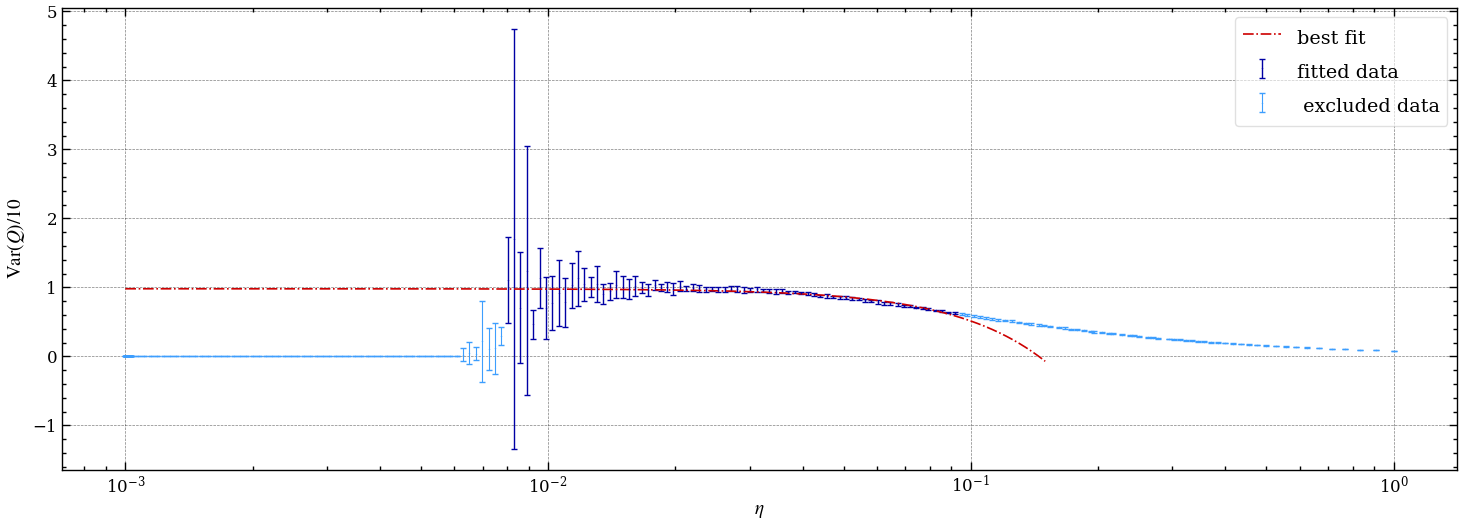

In [402]:
plt.figure(figsize=(18,6))
etas = np.array(etas)
lim = alg['metropolis_eta']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[1][mask], p0,sigma=dvar_q[1][mask], absolute_sigma=True)

w = 1/(dvar_q[1][mask]**2)
chi2 = ((w*(var_q[1][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.15,1000)
plt.errorbar(etas[mask], var_q[1][mask] , dvar_q[1][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,label=rf'fitted data',color=getColor('jet', 30, 1))
plt.errorbar(etas[np.logical_not(mask)], var_q[1][np.logical_not(mask)] , dvar_q[1][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf' excluded data',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.ylabel(r'$\mathrm{Var}(Q)/10$')
plt.xlabel(r'$\eta$')


plt.legend(loc='upper right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)
plt.savefig('fit_metro', dpi=500)

In [406]:
100/79

1.2658227848101267

$a$ = 0.9889 ± 0.0037
$b$ = -46.5252 ± 0.8658
chi2, ndof: 100.34270341293197 79


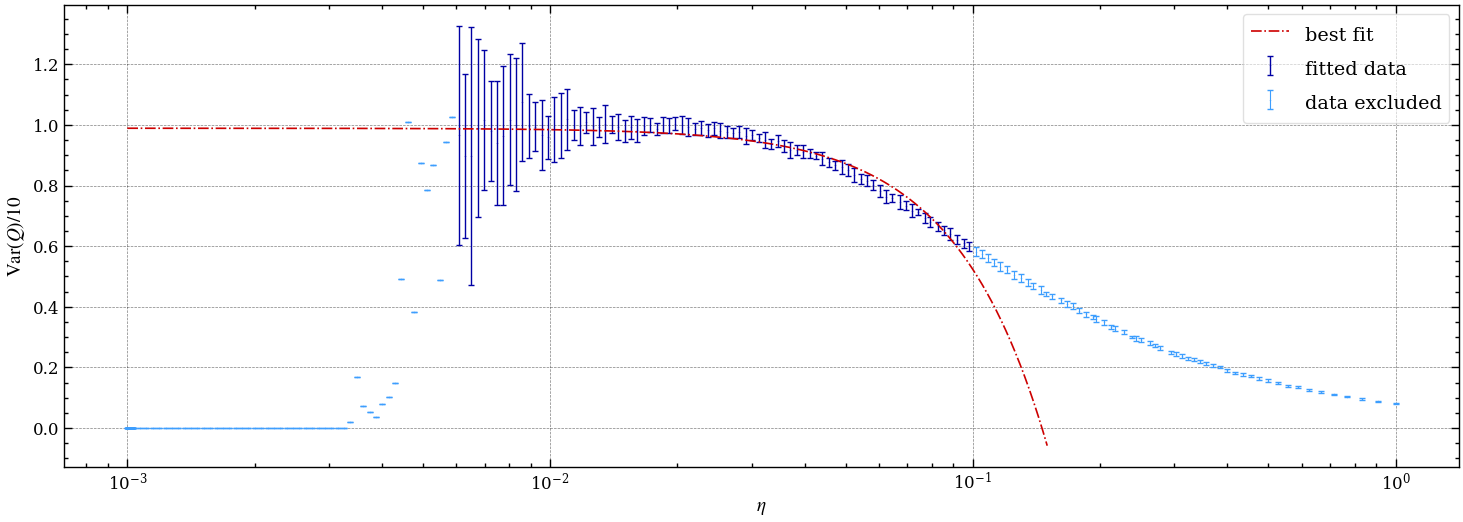

In [403]:
plt.figure(figsize=(18,6))
etas = np.array(etas)
lim = alg['metropolis_half']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[2][mask], p0,sigma=dvar_q[2][mask], absolute_sigma=True)

w = 1/(dvar_q[2][mask]**2)
chi2 = ((w*(var_q[2][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.15,1000)
plt.errorbar(etas[mask], var_q[2][mask] , dvar_q[2][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,label=rf'fitted data',color=getColor('jet', 30, 1))
plt.errorbar(etas[np.logical_not(mask)], var_q[2][np.logical_not(mask)] , dvar_q[1][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data excluded',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.ylabel(r'$\mathrm{Var}(Q)/10$')
plt.xlabel(r'$\eta$')
plt.legend(loc='upper right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)
plt.savefig('fit_metro05', dpi=500)

$a$ = 1.0004 ± 0.0057
$b$ = -54.2785 ± 1.7277
chi2, ndof: 24.469901837783034 119


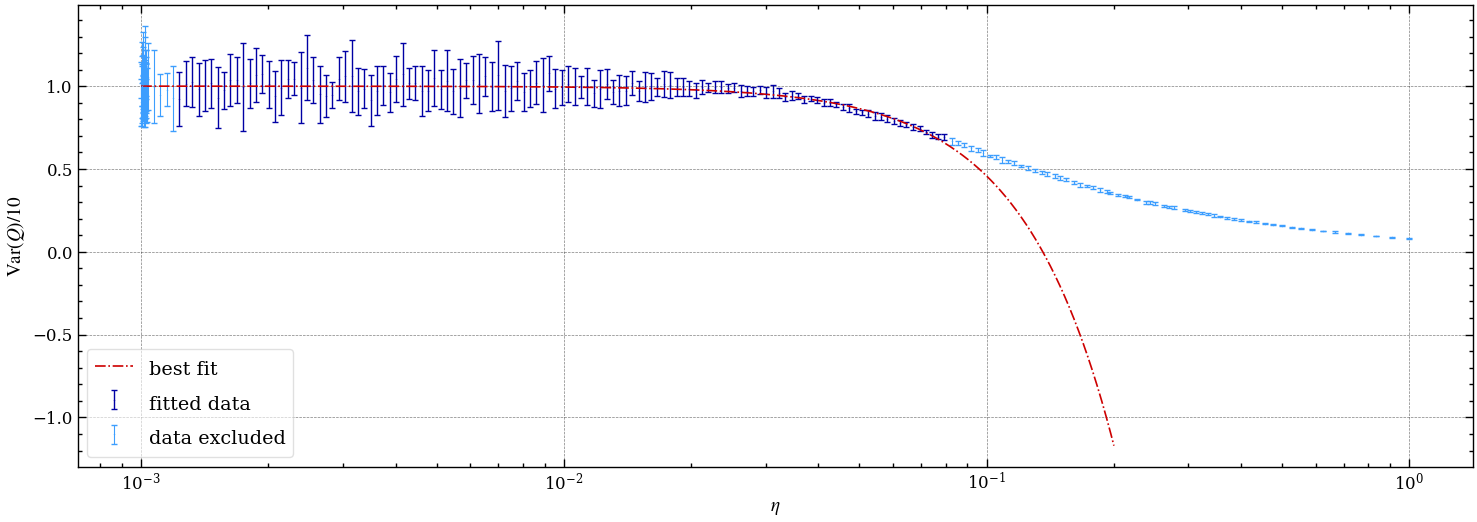

In [404]:
plt.figure(figsize=(18,6))
etas = np.array(etas)
lim = alg['metropolis_tailor']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[0][mask], p0,sigma=dvar_q[0][mask], absolute_sigma=True)

w = 1/(dvar_q[0][mask]**2)
chi2 = ((w*(var_q[0][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.2,1000)
plt.errorbar(etas[mask], var_q[0][mask] , dvar_q[0][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,color=getColor('jet', 30, 1), label=rf'fitted data')
plt.errorbar(etas[np.logical_not(mask)], var_q[0][np.logical_not(mask)] , dvar_q[0][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data excluded',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.ylabel(r'$\mathrm{Var}(Q)/10$')
plt.xlabel(r'$\eta$')
plt.legend(loc='lower left',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)
plt.savefig('fit_metrotailor', dpi=500)

# Accettanza 

In [ ]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
acc_dir = os.getcwd() + '/' + dir1 + '/acc/' + 'acc' 

In [412]:
acceptance = np.full((2,len(etas)),0.) #etas=10/np.sort(N)
for idx, d in enumerate([dir2,dir3]):
    acc_dir = os.getcwd() + '/' + d + '/acc/' + 'acc'
    acc=[]    
    for i,n in enumerate(tqdm(np.sort(N))):
        acc_file = np.loadtxt(f'{acc_dir}_{n}.txt', unpack=True)
        acc.append(acc_file)
    acceptance[idx] = acc

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

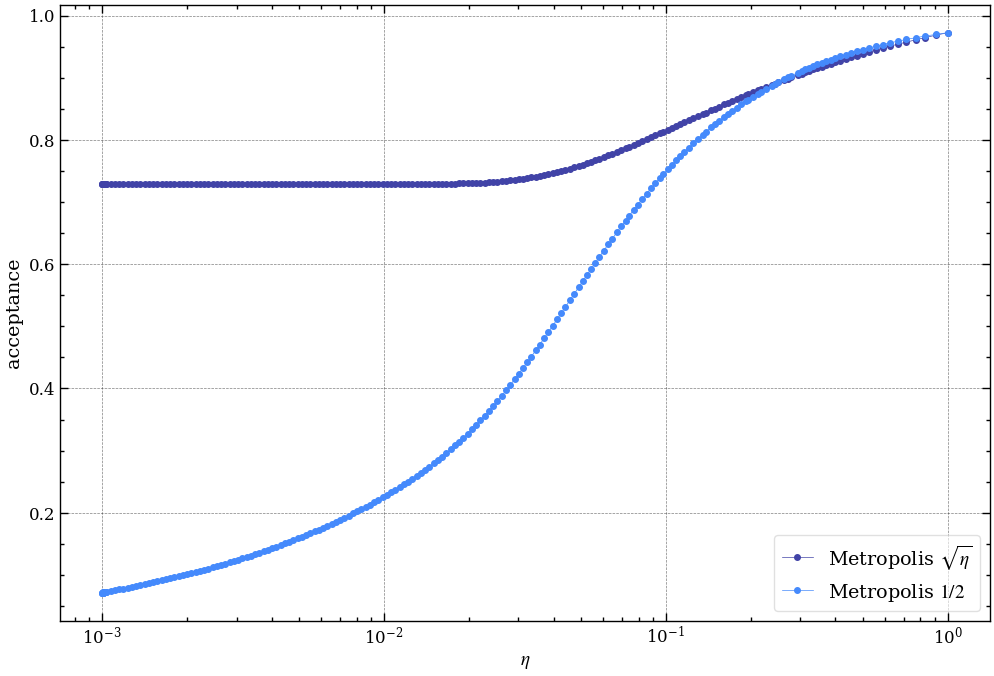

In [432]:
plt.figure(figsize=(12,8))
plt.plot(etas, acceptance[0],'.-',markersize='8', linewidth='.5',color=getColor('turbo', 30, 2), label=r'Metropolis $\sqrt{\eta}$')
plt.plot(etas, acceptance[1],'.-',markersize='8', linewidth='.5',color=getColor('turbo', 30, 5), label=r'Metropolis $1/2$')
plt.xscale('log')
plt.xlabel(r'$\eta$')
plt.ylabel('acceptance')
#plt.yscale('log')
plt.legend(loc='lower right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=1.6, handleheight=1, labelspacing=.5)
plt.savefig('acc', dpi=600)